## Ejercicio 5

**“Flowers”** es un juego de datos compuesto por 16 categorías de flores con unas 1000 imágenes de RGB de 256 x 256 píxeles disponible en Kaggle en el enlace https://www.kaggle.com/datasets/l3llff/flowers.

En la carpeta de datos del Moodle del curso hay una versión reducida de 96 x 96 píxeles. Utilice este dataset para entrenar varios modelos de redes convolucionales que permitan clasificar las 16 flores según las especificaciones que siguen a continuación.

<div style="text-align: center;">
    <img src='../../images/p5-ej5.png' width="60%">
</div>

Para cada modelo a entrenar contabilice la cantidad de **épocas, accuracy** y **tiempo promedio** por época (utilice la clase **EpochTiming** definida en el paquete **tf_utils** de la carpeta **Fuentes** como **callback** para el entrenamiento). Utilice 250 épocas para los entrenamientos y agregue una parada temprana para evitar overfitting.

In [1]:
import zipfile
import os

DATOS_DIR = '../../Datos/'

zip_path = os.path.join(DATOS_DIR, 'FlowersX16.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = DATOS_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: ../../Datos/


### a)

Entrene un modelo que utilice solamente capas **Conv2D**, **MaxPooling2D**, **Flatten** y **Dense**.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from Fuentes.tf_util import EpochTiming
import tensorflow as tf

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.0005        # Tasa de aprendizaje
EPOCAS = 250         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

IMAGES_DIR = DATOS_DIR + 'FlowersX16/'

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        return image/255.0, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_ds = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


#### Creación del modelo

In [10]:
ACTIVATION = 'relu'
PADDING = 'same'

model = Sequential()

model.add(Input(shape=(*IMG_SIZE, 3)))
model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding=PADDING))

model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))

model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
optimizer = optimizers.Adam(ALFA)
model.compile(optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,864 (1.19 MB)

 Trainable params: 312,864 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento del modelo

In [11]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

Epoch 1/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1000ms/step - accuracy: 0.1182 - loss: 2.5741 - val_accuracy: 0.1614 - val_loss: 2.3302
Epoch 2/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 926ms/step - accuracy: 0.2279 - loss: 2.1872 - val_accuracy: 0.3161 - val_loss: 1.9196
Epoch 3/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 971ms/step - accuracy: 0.3844 - loss: 1.7614 - val_accuracy: 0.3926 - val_loss: 1.7501
Epoch 4/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4615 - loss: 1.5637 - val_accuracy: 0.4489 - val_loss: 1.6034
Epoch 5/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 995ms/step - accuracy: 0.4924 - loss: 1.4679 - val_accuracy: 0.5750 - val_loss: 1.2896
Epoch 6/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 968ms/step - accuracy: 0.5067 - loss: 1.4296 - val_accuracy: 0.5702 - val_loss: 1.2888
Epoch 7/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 967ms/step - accuracy: 0.5290 - loss: 1.3588 - val_accuracy: 0.5747 - val_loss: 1.2619
Epoch 8/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 961ms/step - accuracy: 0.5507 - loss: 1.2970 - va

#### Evaluación del modelo

Tiempo promedio por época 47.81 segundos
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.8456 - loss: 0.4549
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8132 - loss: 0.7019


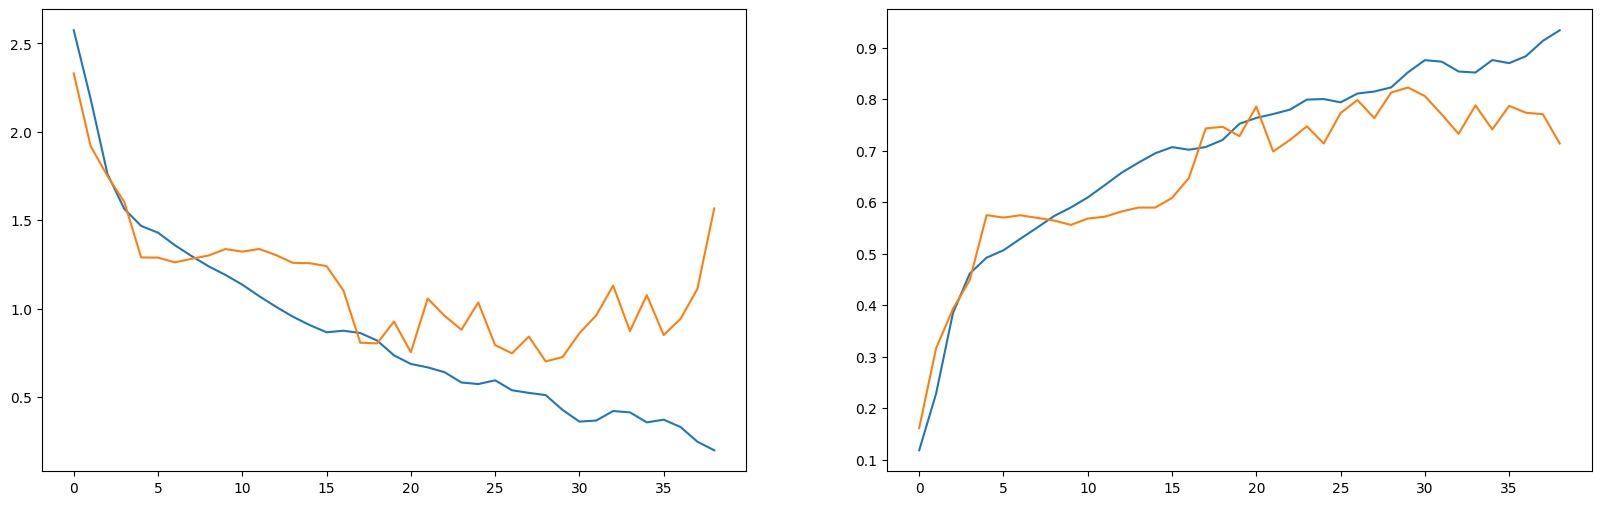

<Figure size 640x480 with 0 Axes>

In [12]:
print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

In [ ]:
model.save('../../Models/p5/flowers_05a_model.keras')

### b)

Agregue capas de **BatchNormalization** después de las capas **MaxPooling2D** y entrene un nuevo modelo.

In [ ]:
ACTIVATION = 'relu'
PADDING = 'same'

model = Sequential()

model.add(Input(shape=(*IMG_SIZE, 3)))
model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())
model.add(Activation(ACTIVATION))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Flatten())
model.add(Dense(128))

model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
optimizer = optimizers.Adam(ALFA)
model.compile(optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])



Epoch 1/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8679 - loss: 0.3840 - val_accuracy: 0.8234 - val_loss: 0.6667
Epoch 2/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8814 - loss: 0.3362 - val_accuracy: 0.8199 - val_loss: 0.7448
Epoch 3/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8757 - loss: 0.3571 - val_accuracy: 0.8021 - val_loss: 0.8537
Epoch 4/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8552 - loss: 0.4068 - val_accuracy: 0.6976 - val_loss: 1.2769
Epoch 5/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8405 - loss: 0.4516 - val_accuracy: 0.7487 - val_loss: 1.0256
Epoch 6/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8582 - loss: 0.4090 - val_accuracy: 0.7697 - val_loss: 0.9280
Epoch 7/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8718 - loss: 0.3630 - val_accuracy: 0.6890 - val_loss: 1.3585
Epoch 8/250
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 929ms/step - accuracy: 0.8976 - loss: 0.3022 - val_accuracy: 0.7741 

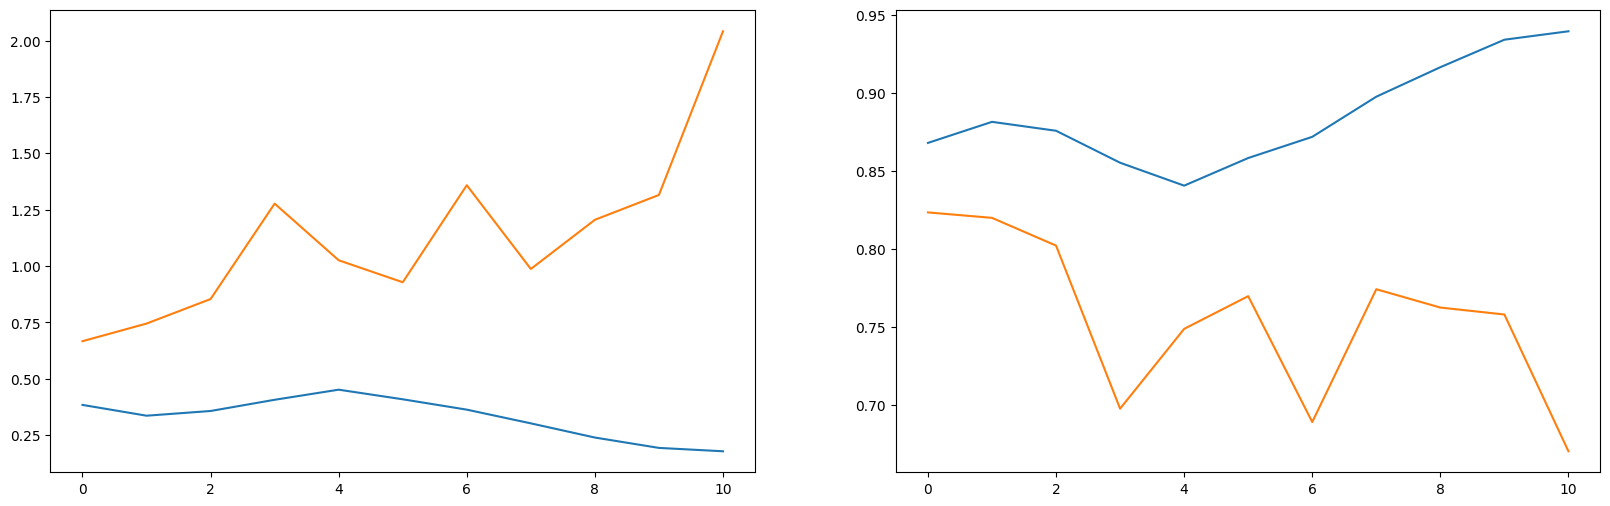

<Figure size 640x480 with 0 Axes>

In [15]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

model.save('../../Models/p5/flowers_05b_model.keras')

### c)

Compare las mediciones de entrenamiento de los modelos a) y b). ¿Qué puede concluir? ¿Por qué?


> **Conclusión:** Con BatchNormalization tardó menos épocas, el aprendizaje al inicio es más rápido (en cuanto a épocas, pero en más lento por época: de todas formas tiene saldo positivo en términos de tiempo). A costa de ello, hizo overfitting, ya que los resultados de validación son significativamente peores a los de entrenamiento.